# 1. Kaggle authentaction API and getting the Dataset

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download jsphyg/weather-dataset-rattle-package

  0% 0.00/3.83M [00:00<?, ?B/s]
100% 3.83M/3.83M [00:00<00:00, 62.7MB/s]


In [6]:
! unzip weather-dataset-rattle-package.zip

Archive:  weather-dataset-rattle-package.zip
  inflating: weatherAUS.csv          


# 2. Impot the used libraries

In [7]:
! pip install xgboost

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import display
from sklearn.metrics import mutual_info_score, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


import pickle

# 3.  Loading the Dataset 

In [9]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [10]:
# The Date column is meaningless for analysis.
del df['Date']

In [11]:
len(df), len(df.columns)

(145460, 22)

# 4. Data Cleaning 

In [12]:
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [13]:
df.columns = df.columns.str.lower()
df.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [14]:
df.dtypes

location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
dtype: object

In [15]:
categorical_variables = ['location',
  'windgustdir',
  'winddir9am',
  'winddir3pm',
  'raintoday']

numerical_variables = ['mintemp',
  'maxtemp',
  'rainfall',
  'evaporation',
  'sunshine',
  'windgustspeed',
  'windspeed9am',
  'windspeed3pm',
  'humidity9am',
  'humidity3pm',
  'pressure9am',
  'pressure3pm',
  'cloud9am',
  'cloud3pm',
  'temp9am',
  'temp3pm']

In [16]:
for col in categorical_variables:
  df[col] = df[col].str.lower()

# 5. EDA

## 5.0 The target variable analysis

In [17]:
df.isnull().sum()

location             0
mintemp           1485
maxtemp           1261
rainfall          3261
evaporation      62790
sunshine         69835
windgustdir      10326
windgustspeed    10263
winddir9am       10566
winddir3pm        4228
windspeed9am      1767
windspeed3pm      3062
humidity9am       2654
humidity3pm       4507
pressure9am      15065
pressure3pm      15028
cloud9am         55888
cloud3pm         59358
temp9am           1767
temp3pm           3609
raintoday         3261
raintomorrow      3267
dtype: int64

In [18]:
df['raintomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [19]:
df = df.drop(df[df.raintomorrow.isnull()].index)
df = df.reset_index(drop=True)

In [20]:
df.isnull().sum()

location             0
mintemp            637
maxtemp            322
rainfall          1406
evaporation      60843
sunshine         67816
windgustdir       9330
windgustspeed     9270
winddir9am       10013
winddir3pm        3778
windspeed9am      1348
windspeed3pm      2630
humidity9am       1774
humidity3pm       3610
pressure9am      14014
pressure3pm      13981
cloud9am         53657
cloud3pm         57094
temp9am            904
temp3pm           2726
raintoday         1406
raintomorrow         0
dtype: int64

In [21]:
df['raintomorrow'].unique()

array(['No', 'Yes'], dtype=object)

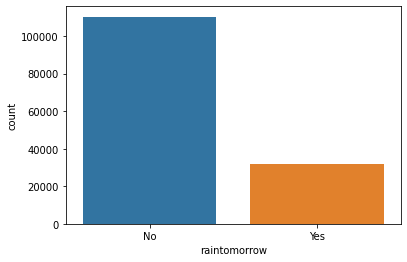

In [22]:
sns.countplot(x='raintomorrow', data=df)

In [23]:
df['raintomorrow'] = (df['raintomorrow'] == 'Yes').astype(int)

## 5.1 Categorical feature analysis

### 5.1.1 Dealing with the missing values

In [24]:
df[categorical_variables]

,location,windgustdir,winddir9am,winddir3pm,raintoday
0,albury,w,w,wnw,no
1,albury,wnw,nnw,wsw,no
2,albury,wsw,w,wsw,no
3,albury,ne,se,e,no
4,albury,w,ene,nw,no
...,...,...,...,...,...
142188,uluru,e,ese,e,no
142189,uluru,e,se,ene,no
142190,uluru,nnw,se,n,no
142191,uluru,n,se,wnw,no


In [25]:
for col in categorical_variables:
  df[col] = df.groupby(df['raintomorrow'])[col].apply(lambda f: f.fillna(f.mode().values[0]))

In [26]:
df[categorical_variables].isnull().sum()

location       0
windgustdir    0
winddir9am     0
winddir3pm     0
raintoday      0
dtype: int64

In [27]:
df['raintoday'] = (df['raintoday'] == 'yes').astype(int).astype(str)
df['raintoday'].value_counts()

0    110738
1     31455
Name: raintoday, dtype: int64

### 5.1.2 Depandancy analysis

In [28]:
mi = df[categorical_variables].apply(lambda a: mutual_info_score(a, df['raintomorrow']))
mi.sort_values(ascending=False)

raintoday      0.042133
windgustdir    0.019381
location       0.013265
winddir3pm     0.007723
winddir9am     0.006762
dtype: float64

## 5.1 Numerical feature analysis

### 5.1.1 Univariate analysis

In [29]:
df[numerical_variables].describe()

,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


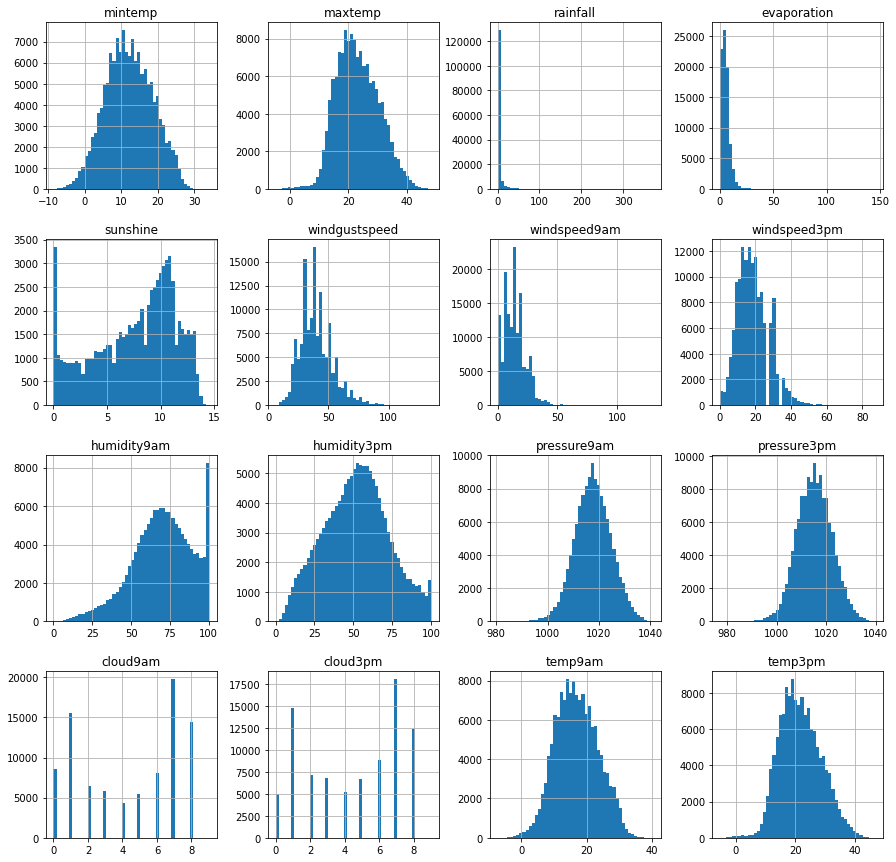

In [30]:
pd.plotting.hist_frame(df[numerical_variables], figsize=(15,15), bins=50, layout=(4, 4));

In [31]:
df[numerical_variables].isnull().sum()

mintemp            637
maxtemp            322
rainfall          1406
evaporation      60843
sunshine         67816
windgustspeed     9270
windspeed9am      1348
windspeed3pm      2630
humidity9am       1774
humidity3pm       3610
pressure9am      14014
pressure3pm      13981
cloud9am         53657
cloud3pm         57094
temp9am            904
temp3pm           2726
dtype: int64

In [32]:
uniformally_distributed_variables = ['mintemp', 'maxtemp', 
                                     'sunshine', 'windgustspeed', 
                                     'windspeed3pm', 'humidity9am', 
                                     'humidity3pm', 'pressure9am',
                                     'pressure3pm', 'temp9am', 
                                     'temp3pm'
                                     ]
for col in uniformally_distributed_variables:
  df[col] = df.groupby(df['raintomorrow'])[col].apply(lambda f: f.fillna(f.mean()))

In [33]:
df[numerical_variables].isnull().sum()

mintemp              0
maxtemp              0
rainfall          1406
evaporation      60843
sunshine             0
windgustspeed        0
windspeed9am      1348
windspeed3pm         0
humidity9am          0
humidity3pm          0
pressure9am          0
pressure3pm          0
cloud9am         53657
cloud3pm         57094
temp9am              0
temp3pm              0
dtype: int64

#### More Checking the other numerical variables distributions

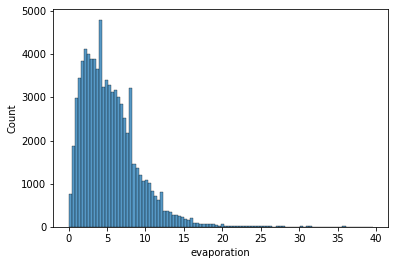

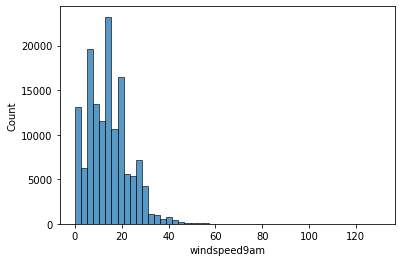

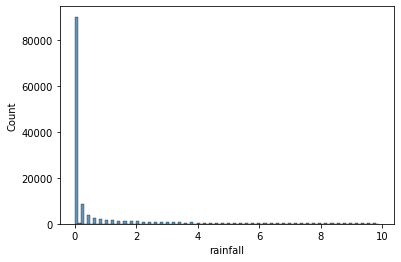

In [34]:
sns.histplot(df.evaporation[df.evaporation < 40], bins=100)
plt.show()
sns.histplot(df.windspeed9am, bins=50)
plt.show()
sns.histplot(df.rainfall[df.rainfall < 10], bins=100);

In [35]:
right_skewed_distributed_variables = ['rainfall', 'evaporation', 'windspeed9am', 'cloud9am', 'cloud3pm']

for col in right_skewed_distributed_variables:
  df[col] = df.groupby(df['raintomorrow'])[col].apply(lambda f: f.fillna(f.median()))

In [36]:
df[numerical_variables].isnull().sum()

mintemp          0
maxtemp          0
rainfall         0
evaporation      0
sunshine         0
windgustspeed    0
windspeed9am     0
windspeed3pm     0
humidity9am      0
humidity3pm      0
pressure9am      0
pressure3pm      0
cloud9am         0
cloud3pm         0
temp9am          0
temp3pm          0
dtype: int64

### 5.1.2 Bivariate analysis

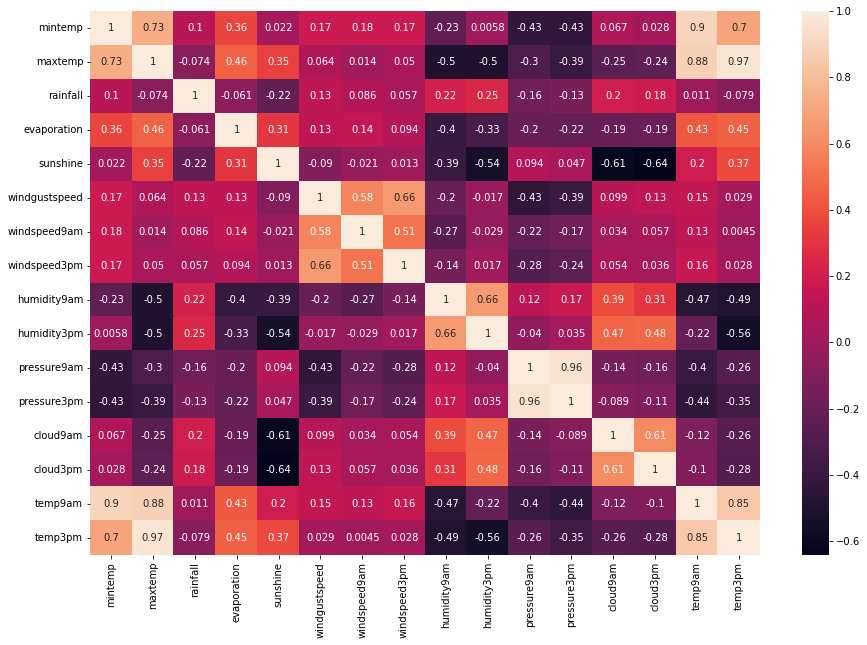

In [37]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(df[numerical_variables].corr(), annot=True, ax=ax)

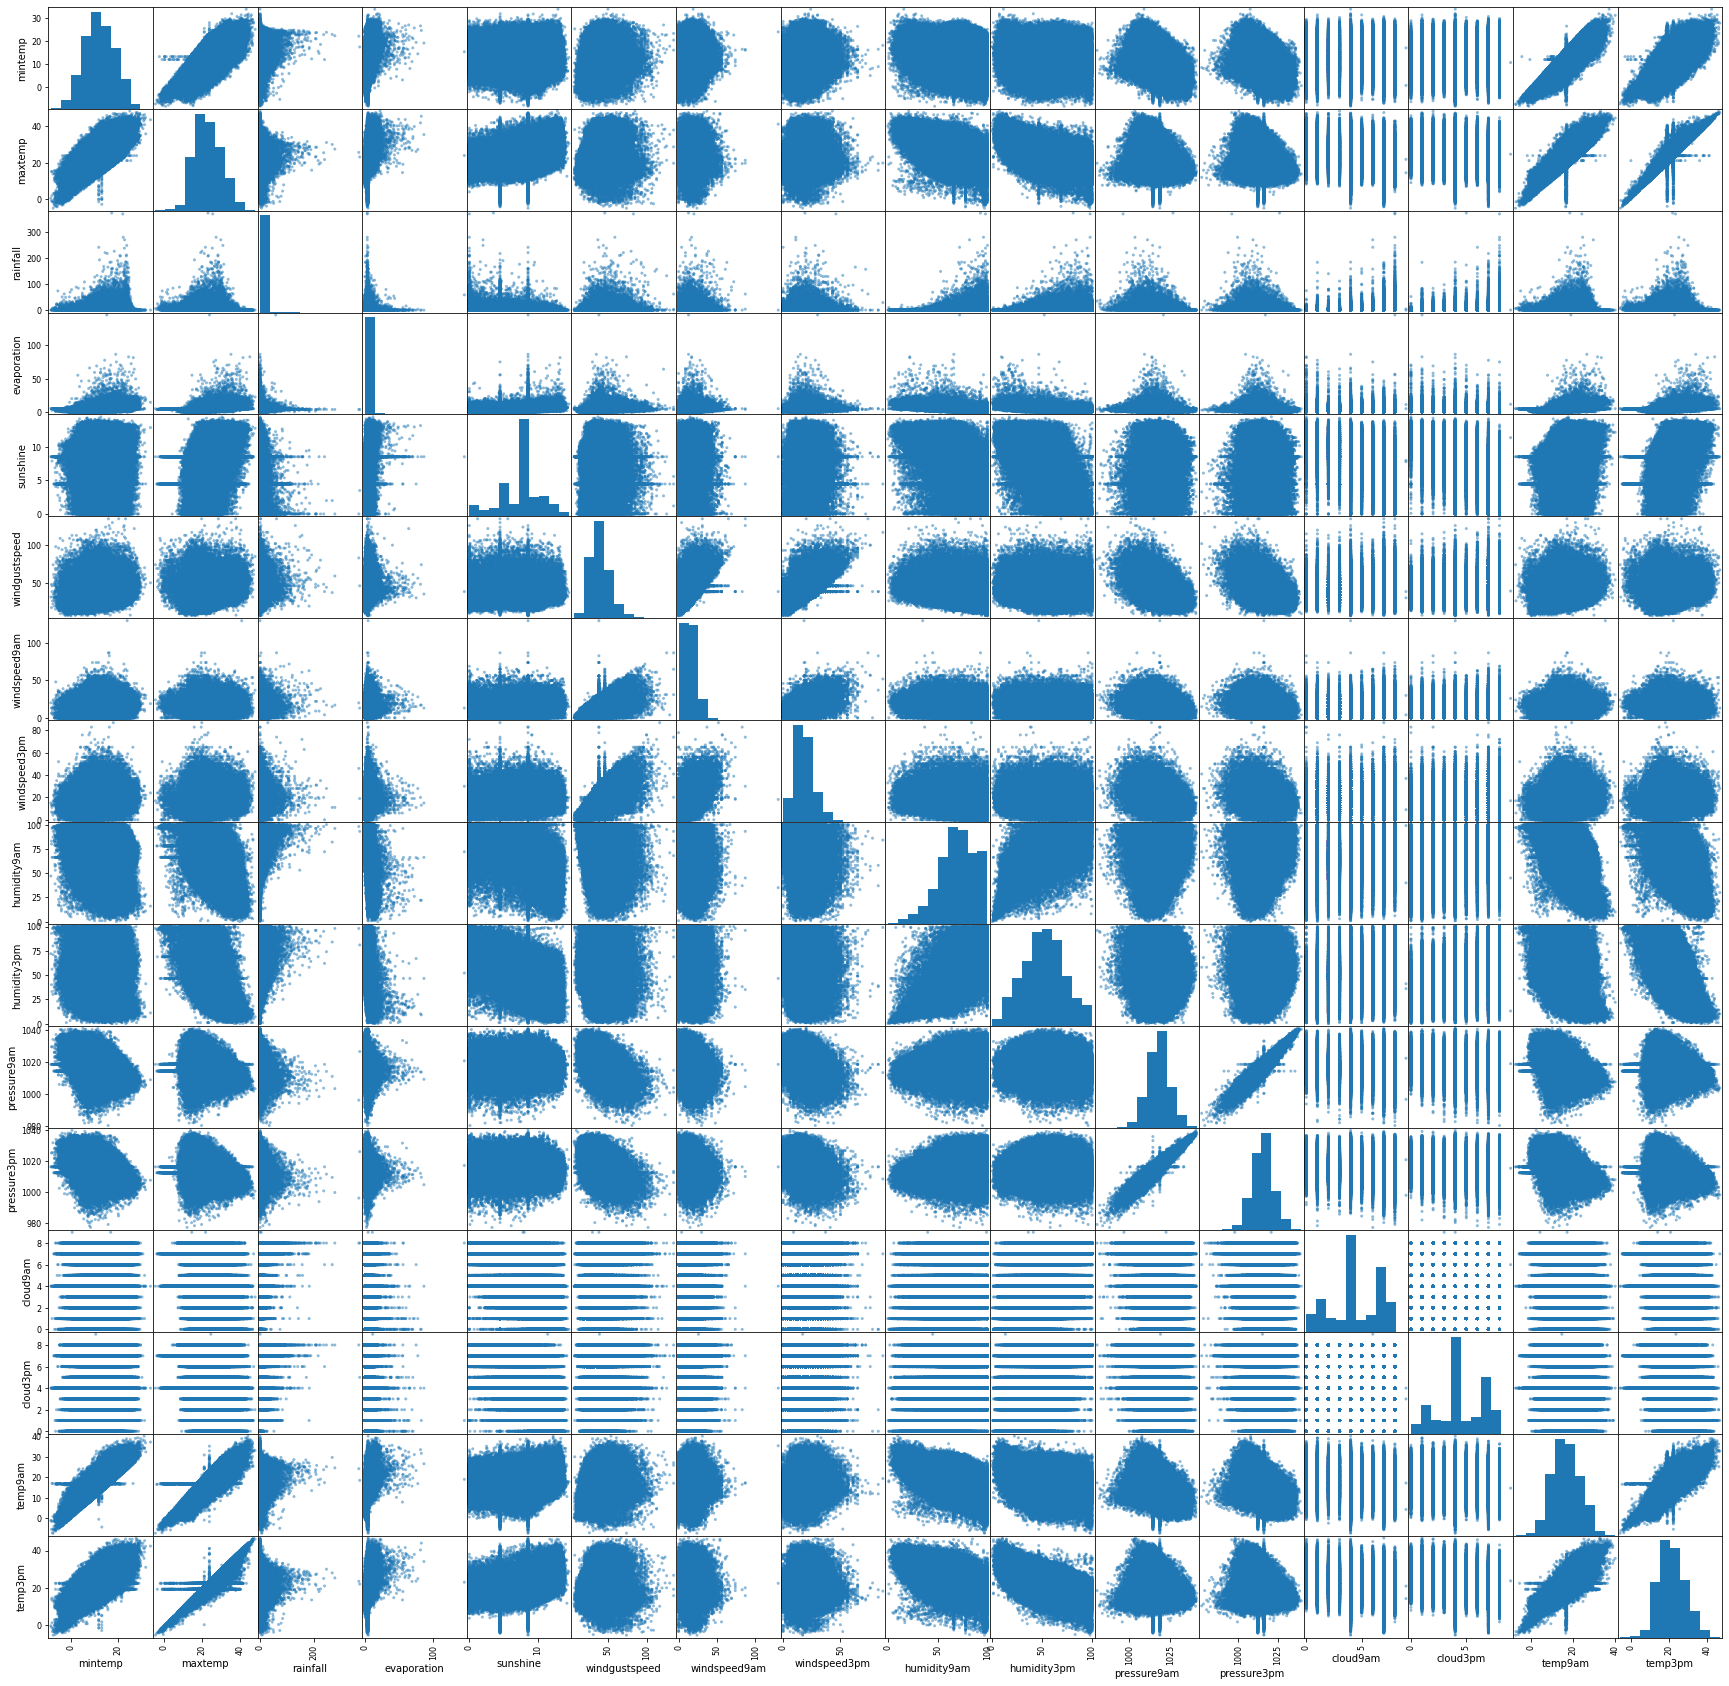

In [38]:
pd.plotting.scatter_matrix(df[numerical_variables], figsize=(30, 30));

# 6. Model Trainings

## 6.1 Train, Validation, Test datasets extraction

In [39]:
full_train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=11)
train, validation = train_test_split(full_train, test_size=0.25, shuffle=True, random_state=11)

In [40]:
len(df), len(train), len(validation), len(test)

(142193, 85315, 28439, 28439)

In [41]:
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)
full_train = full_train.reset_index(drop=True)

In [42]:
y_train = train['raintomorrow'].values
y_val = validation['raintomorrow'].values
y_test = test['raintomorrow'].values
y_full_train = full_train['raintomorrow'].values

In [43]:
del train['raintomorrow']
del validation['raintomorrow']
del test['raintomorrow']
del full_train['raintomorrow']

## 6.2 One-hot encoding

In [44]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train.to_dict(orient='records'))
X_val = dv.transform(validation.to_dict(orient='records'))

In [45]:
dv2 = DictVectorizer(sparse=False)

X_full_train = dv2.fit_transform(full_train.to_dict(orient='records'))
X_test = dv2.transform(test.to_dict(orient='records'))

In [46]:
len(dv.get_feature_names()), len(dv.get_feature_names())

(115, 115)

## 6.3 Logistic Regression Model

In [47]:
evaluation_metrics = pd.DataFrame({'Logistic_Regression_val': [0,0,0,0], 'Decision_Tree_val': [0,0,0,0], 'Random_Forest_val': [0,0,0,0], 
                                   'Logistic_Regression_test': [0,0,0,0], 'Decision_Tree_test': [0,0,0,0], 'Random_Forest_test': [0,0,0,0]}, 
                                  dtype=np.float64,
                                  index=['Accurecy', 'Precision', 'Recall', 'ROC_AUC'])

In [48]:
def add_record_val(y_pred, where):
  evaluation_metrics.loc['Accurecy', where] = accuracy_score(y_val, y_pred >= 0.5)
  evaluation_metrics.loc['ROC_AUC', where] = roc_auc_score(y_val, y_pred)
  evaluation_metrics.loc['Precision', where] = precision_score(y_val, y_pred >= 0.5)
  evaluation_metrics.loc['Recall', where] = recall_score(y_val, y_pred >= 0.5)

In [49]:
def add_record_test(y_pred_test, where):
  evaluation_metrics.loc['Accurecy', where] = accuracy_score(y_test, y_pred_test >= 0.5)
  evaluation_metrics.loc['ROC_AUC', where] = roc_auc_score(y_test, y_pred_test)
  evaluation_metrics.loc['Precision', where] = precision_score(y_test, y_pred_test >= 0.5)
  evaluation_metrics.loc['Recall', where] = recall_score(y_test, y_pred_test >= 0.5)

### 6.3.1 Training and Validating the model

In [50]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=11)
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
y_pred = lr_model.predict_proba(X_val)[:, 1]

In [52]:
add_record_val(y_pred, 'Logistic_Regression_val')

### 6.3.2 Testing the model

In [53]:
lr_model_test = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=11)
lr_model_test.fit(X_full_train, y_full_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
y_pred_test = lr_model_test.predict_proba(X_test)[:, 1]

In [55]:
add_record_test(y_pred_test, 'Logistic_Regression_test')

In [56]:
evaluation_metrics

,Logistic_Regression_val,Decision_Tree_val,Random_Forest_val,Logistic_Regression_test,Decision_Tree_test,Random_Forest_test
Accurecy,0.888604,0.0,0.0,0.891874,0.0,0.0
Precision,0.781086,0.0,0.0,0.798067,0.0,0.0
Recall,0.699279,0.0,0.0,0.702180,0.0,0.0
ROC_AUC,0.927158,0.0,0.0,0.928902,0.0,0.0


## 6.4 Decision Tree

### 6.4.1 Training and Validating the Model

In [57]:
dt_model = DecisionTreeClassifier(random_state=11)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')

In [58]:
y_pred = dt_model.predict_proba(X_val)[:, 1]

In [59]:
roc_auc_score(y_val, y_pred)

0.8658089817922536

### 6.4.2 Parameters Tunning

In [60]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 40, 80, 100, None]

for depth in depths: 
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=11)
    dt_model.fit(X_train, y_train)
    
    y_pred = dt_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.5f' % (depth, auc))

   1 -> 0.83445
   2 -> 0.91647
   3 -> 0.94336
   4 -> 0.95432
   5 -> 0.95974
   6 -> 0.96299
  10 -> 0.96123
  15 -> 0.91115
  20 -> 0.87223
  40 -> 0.86581
  80 -> 0.86581
 100 -> 0.86581
None -> 0.86581


In [61]:
scores = []

for depth in [3, 4, 5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt_model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=11)
        dt_model.fit(X_train, y_train)

        y_pred = dt_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [62]:
aggregation_results = pd.DataFrame(data=scores, columns=['depth', 'minmum_leaf_samples', 'ROC_AUC'])
aggregation_results

,depth,minmum_leaf_samples,ROC_AUC
0,3,1,0.943363
1,3,5,0.943363
2,3,10,0.943363
3,3,15,0.943363
4,3,20,0.943363
5,3,500,0.942888
6,3,100,0.943363
7,3,200,0.943363
8,4,1,0.954317
9,4,5,0.954317


In [63]:
pivot_table = aggregation_results.pivot(index='depth', columns=['minmum_leaf_samples'], values=['ROC_AUC'])

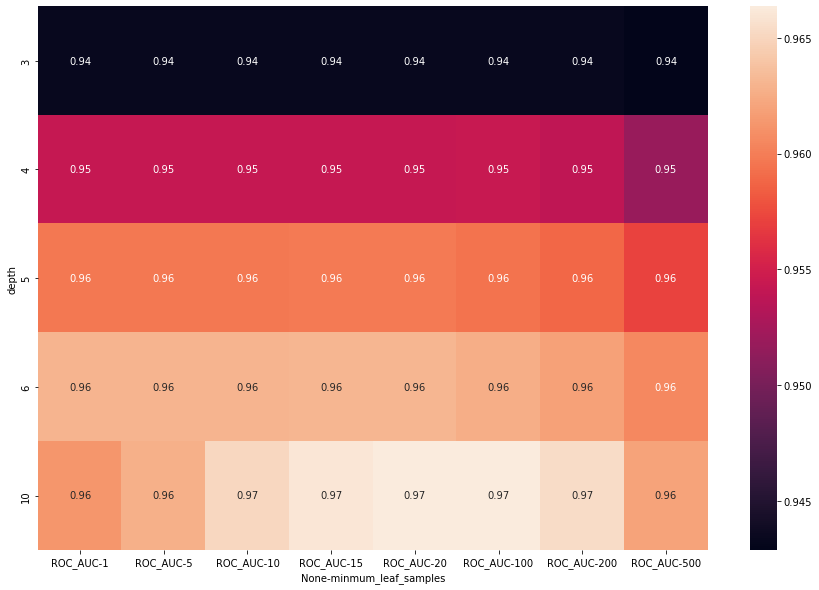

In [64]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(pivot_table, annot=True, ax=ax)

In [65]:
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [66]:
y_pred = dt_model.predict_proba(X_val)[:, 1]

In [67]:
add_record_val(y_pred, 'Decision_Tree_val')

### 6.4.3 Testing The model

In [68]:
dt_model_test = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100, random_state=11)
dt_model_test.fit(X_full_train, y_full_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=11, splitter='best')

In [69]:
y_pred_test = dt_model_test.predict_proba(X_test)[:, 1]

In [70]:
add_record_test(y_pred_test, 'Decision_Tree_test')

In [71]:
evaluation_metrics

,Logistic_Regression_val,Decision_Tree_val,Random_Forest_val,Logistic_Regression_test,Decision_Tree_test,Random_Forest_test
Accurecy,0.888604,0.920286,0.0,0.891874,0.924575,0.0
Precision,0.781086,0.868964,0.0,0.798067,0.894199,0.0
Recall,0.699279,0.759015,0.0,0.702180,0.758002,0.0
ROC_AUC,0.927158,0.966351,0.0,0.928902,0.969868,0.0


## 6.5 Random Forest Model

### 6.5.1 Training and Validating the Model

In [72]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=11)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [73]:
y_pred = rf_model.predict_proba(X_val)[:, 1]
y_pred

array([1.  , 0.06, 0.64, ..., 0.98, 1.  , 0.  ])

In [74]:
roc_auc_score(y_val, y_pred)

0.9726923320695409

### 6.5.2 Parameters Tunning

In [75]:
scores = []

for n in range(10, 201, 10):
    rf_model = RandomForestClassifier(n_estimators=n, random_state=11)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [76]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

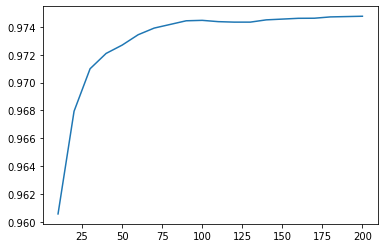

In [77]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [78]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf_model = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=11)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [79]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores_tunning = pd.DataFrame(scores, columns=columns)
df_scores_tunning

,max_depth,n_estimators,auc
0,5,10,0.947695
1,5,20,0.946670
2,5,30,0.948714
3,5,40,0.948561
4,5,50,0.948523
5,5,60,0.949601
6,5,70,0.950218
7,5,80,0.950073
8,5,90,0.950693
9,5,100,0.950171


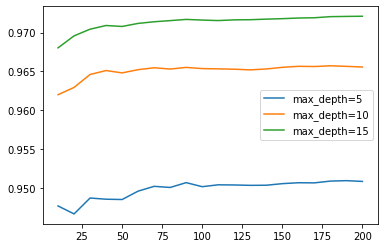

In [80]:
for d in [5, 10, 15]:
    df_subset = df_scores_tunning[df_scores_tunning.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [81]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf_model = RandomForestClassifier(n_estimators=n,
                                    max_depth=15,
                                    min_samples_leaf=s,
                                    random_state=11)
        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [82]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores_tunning2 = pd.DataFrame(scores, columns=columns)

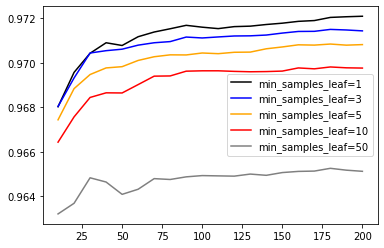

In [83]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores_tunning2[df_scores_tunning2.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [84]:
rf_model = RandomForestClassifier(n_estimators=200, 
                                 max_depth=15,
                                 min_samples_leaf=1,
                                 random_state=11)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [85]:
y_pred = rf_model.predict_proba(X_val)[:, 1]

In [86]:
add_record_val(y_pred, 'Random_Forest_val')

### 6.5.3 Testing the Model

In [87]:
rf_model_test = RandomForestClassifier(n_estimators=200, 
                                 max_depth=15,
                                 min_samples_leaf=1,
                                 random_state=11)
rf_model_test.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [88]:
y_pred_test = rf_model_test.predict_proba(X_test)[:, 1]

In [89]:
add_record_test(y_pred_test, 'Random_Forest_test')

In [90]:
evaluation_metrics

,Logistic_Regression_val,Decision_Tree_val,Random_Forest_val,Logistic_Regression_test,Decision_Tree_test,Random_Forest_test
Accurecy,0.888604,0.920286,0.930799,0.891874,0.924575,0.931854
Precision,0.781086,0.868964,0.888889,0.798067,0.894199,0.903295
Recall,0.699279,0.759015,0.790216,0.702180,0.758002,0.784289
ROC_AUC,0.927158,0.966351,0.972092,0.928902,0.969868,0.973318


# 6.6 XGBoosting

In [91]:
D_train = xgb.DMatrix(X_train, label=y_train, feature_names=dv.get_feature_names())
D_val = xgb.DMatrix(X_val, label=y_val, feature_names=dv.get_feature_names())
D_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv2.get_feature_names())
D_test = xgb.DMatrix(X_test, label=y_test, feature_names=dv2.get_feature_names())

In [92]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, D_train, num_boost_round=100)

In [93]:
y_pred = xgb_model.predict(D_val)

In [94]:
roc_auc_score(y_val, y_pred)

0.980342646957297

In [95]:
xgb_model_test = xgb.train(xgb_params, D_full_train, num_boost_round=100)

In [96]:
y_pred_test = xgb_model_test.predict(D_test)

In [97]:
roc_auc_score(y_test, y_pred_test)

0.9823032918936907

In [98]:
add_record_val(y_pred, 'XGBoosting_val')
add_record_test(y_pred_test, 'XGBoosting_test')

In [99]:
evaluation_metrics = evaluation_metrics[['Logistic_Regression_val',
 'Decision_Tree_val',
 'Random_Forest_val',
 'XGBoosting_val',
 'Logistic_Regression_test',
 'Decision_Tree_test',
 'Random_Forest_test',
 'XGBoosting_test']]


In [100]:
evaluation_metrics

,Logistic_Regression_val,Decision_Tree_val,Random_Forest_val,XGBoosting_val,Logistic_Regression_test,Decision_Tree_test,Random_Forest_test,XGBoosting_test
Accurecy,0.888604,0.920286,0.930799,0.940750,0.891874,0.924575,0.931854,0.940961
Precision,0.781086,0.868964,0.888889,0.900085,0.798067,0.894199,0.903295,0.910353
Recall,0.699279,0.759015,0.790216,0.827689,0.702180,0.758002,0.784289,0.821246
ROC_AUC,0.927158,0.966351,0.972092,0.980343,0.928902,0.969868,0.973318,0.982303


# 7. Model Saving and Loading

In [101]:
model_name = 'xgb_model'
model_file = f'model_{model_name}.bin'

In [102]:
with open(model_file, 'wb') as m_out:
  pickle.dump(xgb_model_test, m_out)

In [103]:
with open(model_file, 'rb') as m_out:
  loaded_model = pickle.load(m_out)

In [111]:
dd = xgb.DMatrix(np.array([list(X_train[10421])]), label=[y_train[10421]], feature_names=dv.get_feature_names())

In [112]:
loaded_model.predict(dd)[0]

0.056841545

In [110]:
y_train[10421]

0